In [60]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import sys
sys.path.append('../qubo')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import polynomial
import yaml

## Inventory ##

In [2]:
d = pd.read_csv('../qubo/data/instances/inventory.csv', index_col=['instance', 'penalty_weight_conflict', 'penalty_weight_unique', 'embedding'])
d.head(18)

NLogQubits  \
instance                                           penalty_weight_conflict penalty_weight_unique embedding               
data/instances/instances_d3/atm_instance_partit... 0.5                     0.5                   NaN                14   
                                                                                                 0.0                14   
                                                                                                 1.0                14   
                                                                                                 2.0                14   
                                                                                                 3.0                14   
                                                                                                 4.0                14   
data/instances/instances_d3/atm_instance_partit... 0.5                     0.5                   NaN                14   
                                                                                                 0.0                14   
                                                                                                 1.0                14   
                                                                                                 2.0                14   
                                                                                                 3.0                14   
                                                                                                 4.0                14   
data/instances/instances_d3/atm_instance_partit... 0.5                     0.5                   NaN                14   
                                                                                                 0.0                14   
                                                                                                 1.0                14   
                                                                                                 2.0                14   
                                                                                                 3.0                14   
                                                                                                 4.0                14   

                                                                                                            NPhysQubits  \
instance                                           penalty_weight_conflict penalty_weight_unique embedding                
data/instances/instances_d3/atm_instance_partit... 0.5                     0.5                   NaN                NaN   
                                                                                                 0.0               47.0   
                                                                                                 1.0               46.0   
                                                                                                 2.0               47.0   
                                                                                                 3.0               40.0   
                                                                                                 4.0               52.0   
data/instances/instances_d3/atm_instance_partit... 0.5                     0.5                   NaN                NaN   
                                                                                                 0.0               48.0   
                                                                                                 1.0               38.0   
                                                                                                 2.0               54.0   
                                                                                                 3.0               39.0   
                                                                    

## Add number of conflicts, number of flights and partition number as columns to the inventory ##

In [3]:
d = pd.read_csv('../qubo/data/instances/inventory.csv')

In [4]:
def parseInstance(instancefile):
    delay = int(instancefile.split('/')[2].split('_d')[1])
    s = instancefile.split('/')[3].split('_partition')[1].split('_')
    partition = int(s[0])
    flights = int(s[1].lstrip('f'))
    conflicts = int(s[2].lstrip('c').rstrip('.yaml'))

    return delay, partition, flights, conflicts

In [5]:
info = np.array([list(parseInstance(i)) for i in d.instance.values])

In [6]:
d['delayStep'] = info[:, 0]
d['partitionNumber'] = info[:, 1]
d['numFlights'] = info[:, 2]
d['numConflicts'] = info[:, 3]

In [7]:
inventoryProcessed = d.set_index('instance')

In [8]:
inventoryProcessed.to_csv('inventoryProcessed.csv')

In [9]:
inventoryProcessed.set_index(['numFlights', 'numConflicts', 'delayStep']).head()

NLogQubits  NPhysQubits  \
numFlights numConflicts delayStep                            
2          1            3                  14          NaN   
                        3                  14         47.0   
                        3                  14         46.0   
                        3                  14         47.0   
                        3                  14         40.0   

                                   SuccessProbability  embedding  exact  \
numFlights numConflicts delayStep                                         
2          1            3                         NaN        NaN   True   
                        3                      0.0901        0.0  False   
                        3                      0.4758        1.0  False   
                        3                      0.0001        2.0  False   
                        3                      0.1986        3.0  False   

                                  isValid  maxCoefficientRangRatio  \
numFlights numConflicts delayStep                                    
2          1            3            True                      NaN   
                        3            True                   136.00   
                        3            True                   101.00   
                        3            True                    16.75   
                        3            True                   130.50   

                                   penalty_weight_conflict  \
numFlights numConflicts delayStep                            
2          1            3                              0.5   
                        3                              0.5   
                        3                              0.5   
                        3                              0.5   
                        3                              0.5   

                                   penalty_weight_unique   repeatTo99  \
numFlights numConflicts delayStep                                       
2          1            3                            0.5          NaN   
                        3                            0.5     48.77295   
                        3                            0.5      7.13005   
                        3                            0.5  46049.39924   
                        3                            0.5     20.80069   

                                                                      version  \
numFlights numConflicts delayStep                                               
2          1            3          510d90d3d952a49bd329ab539627692f957ce1ee\n   
                        3          510d90d3d952a49bd329ab539627692f957ce1ee\n   
                        3          510d90d3d952a49bd329ab539627692f957ce1ee\n   
                        3          510d90d3d952a49bd329ab539627692f957ce1ee\n   
                        3          510d90d3d952a49bd329ab539627692f957ce1ee\n   

                                   partitionNumber  
numFlights numConflicts delayStep                   
2          1            3                        0  
                        3                        0  
                        3                        0  
                        3                        0  
                        3                        0

## Restrict to finished runs (partitions 0 to 80)

In [27]:
inventoryProcessed = inventoryProcessed[inventoryProcessed.partitionNumber < 80]
iv = inventoryProcessed

## Check if all data is there ##

In [28]:
complete = True
for delayStep in (3, 6, 9):
    for partitionNumber in range(0, 1):
        for pw in (0.5, 1, 2):
            subset = iv[(iv.delayStep == 3) & (iv.partitionNumber == 0) & (iv.penalty_weight_conflict == 0.5)]
            if len(subset) != 6:
                complete = False
                print delayStep, partitionNumber, pw, subset
                break
if complete:
    print "All data is there"
            

All data is there


In [32]:
%matplotlib inline

## Number of logical and physical qubits ##

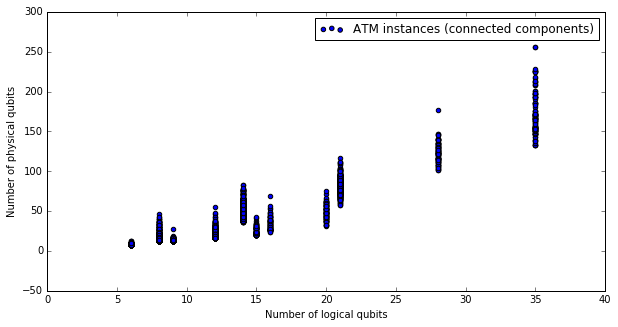

In [33]:
dvalid = iv[iv['isValid']==True]
nLogQubitsSuccess = dvalid.NLogQubits
nPhyQubitsSuccess = dvalid.NPhysQubits
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(nLogQubitsSuccess, nPhyQubitsSuccess, label='ATM instances (connected components)');
ax.set_xlabel('Number of logical qubits')
ax.set_ylabel('Number of physical qubits')
ax.legend();
plt.show();

## Success probability in dependence of the number of delay steps ##
The maximum delay is always 18 minutes. The delay step size is 3, 6 or 9. 

In [34]:
dvalid = iv[iv['isValid']==True]
dd = dvalid.reset_index()
ddd = dd[dd.instance.apply(lambda e: "_d9" in e)]
successProb_d9 = ddd['SuccessProbability'].dropna().values

ddd = dd[dd.instance.apply(lambda e: "_d6" in e)]
successProb_d6 = ddd['SuccessProbability'].dropna().values

ddd = dd[dd.instance.apply(lambda e: "_d3" in e)]
successProb_d3 = ddd['SuccessProbability'].dropna().values

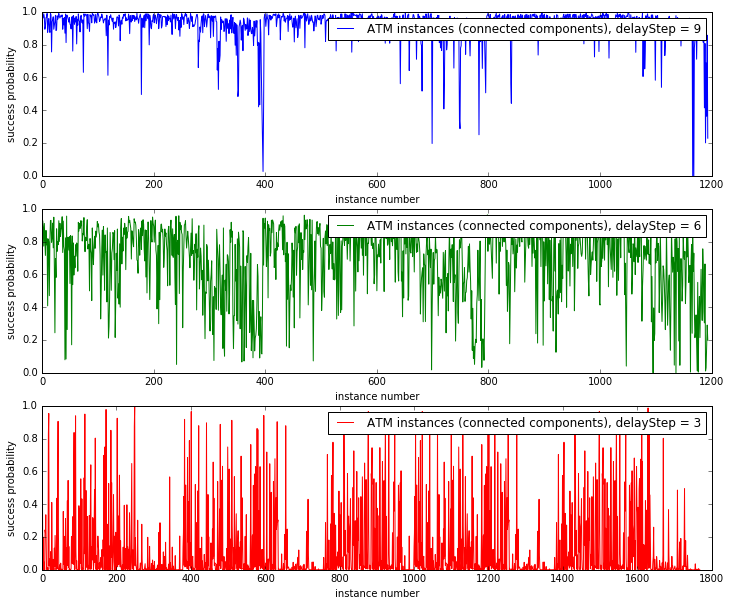

In [61]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('instance number')
ax1.set_ylabel('success probability')

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('instance number')
ax2.set_ylabel('success probability')

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('instance number')
ax3.set_ylabel('success probability')

ax1.plot(successProb_d9, label='ATM instances (connected components), delayStep = 9');
ax2.plot(successProb_d6, c='g', label='ATM instances (connected components), delayStep = 6');
ax3.plot(successProb_d3, c='r', label='ATM instances (connected components), delayStep = 3');

ax1.legend()
ax2.legend()
ax3.legend()

plt.show();

## Success probability depending on instance parameters ##

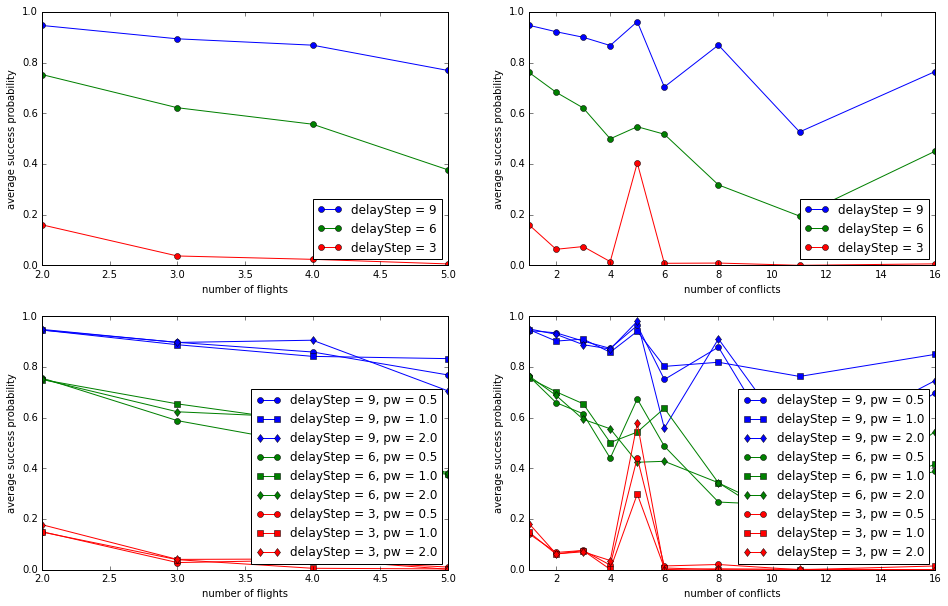

In [62]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['SuccessProbability'].mean()

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(2,2,1)
d9.plot(marker = 'o', label='delayStep = 9', ax=ax1)
d6.plot(marker = 'o', label='delayStep = 6', ax=ax1)
d3.plot(marker = 'o', label='delayStep = 3', ax=ax1)
ax1.set_ylabel('average success probability');
ax1.set_xlabel('number of flights');
ax1.legend(loc='lower right');

# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['SuccessProbability'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['SuccessProbability'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['SuccessProbability'].mean()

ax2 = fig.add_subplot(2,2,2)
d9.plot(marker = 'o', label='delayStep = 9', ax=ax2)
d6.plot(marker = 'o', label='delayStep = 6', ax=ax2)
d3.plot(marker = 'o', label='delayStep = 3', ax=ax2)
ax2.set_ylabel('average success probability');
ax2.set_xlabel('number of conflicts');
ax2.legend(loc='lower right');

# vs. flights, different penalty weights
d3_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d3_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d6_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numFlights')['SuccessProbability'].mean()
d9_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numFlights')['SuccessProbability'].mean()

ax3 = fig.add_subplot(2,2,3)
d9_pw05.plot(marker = 'o', c='b', label='delayStep = 9, pw = 0.5', ax=ax3)
d9_pw10.plot(marker = 's', c='b', label='delayStep = 9, pw = 1.0', ax=ax3)
d9_pw20.plot(marker = 'd', c='b', label='delayStep = 9, pw = 2.0', ax=ax3)
d6_pw05.plot(marker = 'o', c='g', label='delayStep = 6, pw = 0.5', ax=ax3)
d6_pw10.plot(marker = 's', c='g', label='delayStep = 6, pw = 1.0', ax=ax3)
d6_pw20.plot(marker = 'd', c='g', label='delayStep = 6, pw = 2.0', ax=ax3)
d3_pw05.plot(marker = 'o', c='r', label='delayStep = 3, pw = 0.5', ax=ax3)
d3_pw10.plot(marker = 's', c='r', label='delayStep = 3, pw = 1.0', ax=ax3)
d3_pw20.plot(marker = 'd', c='r', label='delayStep = 3, pw = 2.0', ax=ax3)
ax3.set_ylabel('average success probability');
ax3.set_xlabel('number of flights');
ax3.legend(loc='lower right');

# vs. conflicts, different penalty weights
d3_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d3_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d3_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==3) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d6_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==6) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw05 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 0.5)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw10 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 1.0)].groupby('numConflicts')['SuccessProbability'].mean()
d9_pw20 = inventoryProcessed[(inventoryProcessed['delayStep']==9) & (inventoryProcessed['penalty_weight_conflict'] == 2.0)].groupby('numConflicts')['SuccessProbability'].mean()

ax4 = fig.add_subplot(2,2,4)
d9_pw05.plot(marker = 'o', c='b', label='delayStep = 9, pw = 0.5', ax=ax4)
d9_pw10.plot(marker = 's', c='b', label='delayStep = 9, pw = 1.0', ax=ax4)
d9_pw20.plot(marker = 'd', c='b', label='delayStep = 9, pw = 2.0', ax=ax4)
d6_pw05.plot(marker = 'o', c='g', label='delayStep = 6, pw = 0.5', ax=ax4)
d6_pw10.plot(marker = 's', c='g', label='delayStep = 6, pw = 1.0', ax=ax4)
d6_pw20.plot(marker = 'd', c='g', label='delayStep = 6, pw = 2.0', ax=ax4)
d3_pw05.plot(marker = 'o', c='r', label='delayStep = 3, pw = 0.5', ax=ax4)
d3_pw10.plot(marker = 's', c='r', label='delayStep = 3, pw = 1.0', ax=ax4)
d3_pw20.plot(marker = 'd', c='r', label='delayStep = 3, pw = 2.0', ax=ax4)
ax4.set_ylabel('average success probability');
ax4.set_xlabel('number of conflicts');
ax4.legend(loc='lower right');

## Maximum coefficient range ratio of embedded QUBO for different delay step sizes ##

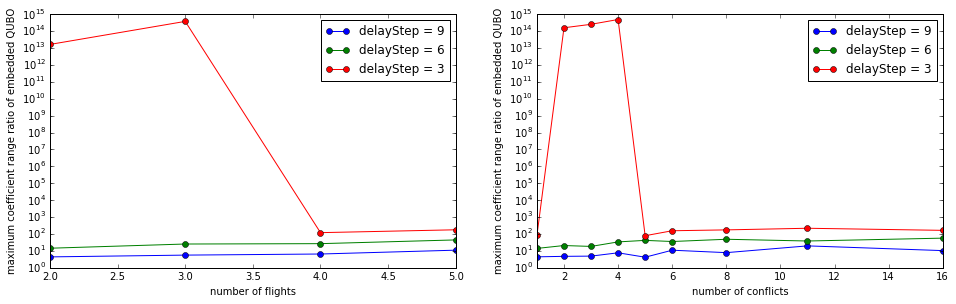

In [63]:
# vs. flights
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numFlights')['maxCoefficientRangRatio'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numFlights')['maxCoefficientRangRatio'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numFlights')['maxCoefficientRangRatio'].mean()

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(2,2,1)
d9.plot(marker = 'o', label='delayStep = 9', ax=ax1)
d6.plot(marker = 'o', label='delayStep = 6', ax=ax1)
d3.plot(marker = 'o', label='delayStep = 3', ax=ax1)
ax1.set_ylabel('maximum coefficient range ratio of embedded QUBO');
ax1.set_xlabel('number of flights');
ax1.legend();
ax1.set_yscale('log')


# vs. conflicts
d3 = inventoryProcessed[inventoryProcessed['delayStep']==3].groupby('numConflicts')['maxCoefficientRangRatio'].mean()
d6 = inventoryProcessed[inventoryProcessed['delayStep']==6].groupby('numConflicts')['maxCoefficientRangRatio'].mean()
d9 = inventoryProcessed[inventoryProcessed['delayStep']==9].groupby('numConflicts')['maxCoefficientRangRatio'].mean()

ax2 = fig.add_subplot(2,2,2)
d9.plot(marker = 'o', label='delayStep = 9', ax=ax2)
d6.plot(marker = 'o', label='delayStep = 6', ax=ax2)
d3.plot(marker = 'o', label='delayStep = 3', ax=ax2)
ax2.set_ylabel('maximum coefficient range ratio of embedded QUBO');
ax2.set_xlabel('number of conflicts');
ax2.set_yscale('log')
ax2.legend();

## Correlation of low success probability with high ratio of coefficients in the embedded QUBO ##

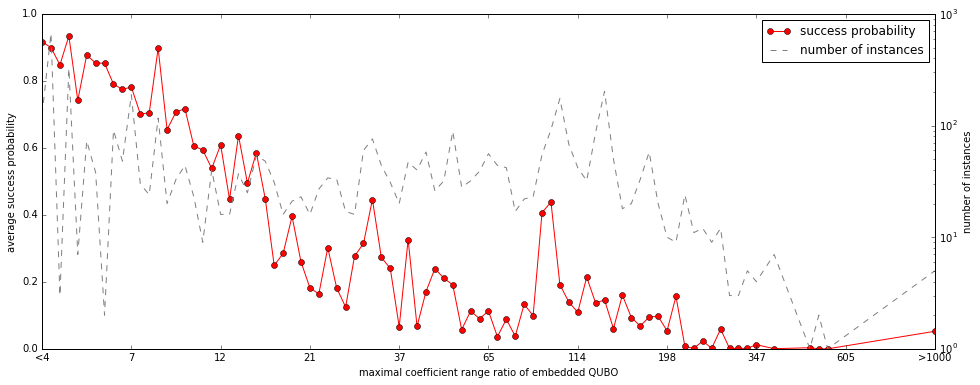

In [64]:
iv = inventoryProcessed
crr_min = iv.maxCoefficientRangRatio.min()
crr_max = iv.maxCoefficientRangRatio.max()
bins = np.logspace(np.log2(crr_min)+1, np.log2(1000), 100, base=2)
x = iv.groupby(np.digitize(iv.maxCoefficientRangRatio, bins))['SuccessProbability'].mean()
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)
x.plot(marker='o', color='r', ax=ax1, label='success probability');
ticks = range(0, 110, 10)
labels = ['<4'] + [int(np.round(bins[t])) for t in ticks[1:-1]] + ['>1000']
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.set_xlabel('maximal coefficient range ratio of embedded QUBO')
ax1.set_ylabel('average success probability');

y = iv.groupby(np.digitize(iv.maxCoefficientRangRatio, bins))['SuccessProbability'].count()
ax2 = ax1.twinx()
y.plot(linestyle='--', color='gray', ax=ax2, label='number of instances');
y.plot(linestyle='--', color='gray', ax=ax1, label='number of instances');
ax1.set_ybound(upper=1)
ax2.set_ylabel('number of instances');
ax2.set_yscale('log')
ax1.legend(loc='upper right');

